<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO" />

# Walmart : predict weekly sales

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets,discount department stores, and grocery stores from the United States, headquartered in Bentonville,Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

## Deliverable 📬

To complete this project, your team should:

- Create some visualizations
- Train at least one **linear regression model** on the dataset, that predicts the amount of weekly sales as a function of the other variables
- Assess the performances of the model by using a metric that is relevant for regression problems
- Interpret the coefficients of the model to identify what features are important for the prediction
- Train at least one model with **regularization (Lasso or Ridge)** to reduce overfitting

### Import libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso

warnings.filterwarnings("ignore")
sns.set()

### Import dataset

In [14]:
df = pd.read_csv("src/walmart_store_sales.csv")
print(df.shape)
df.head()

(150, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


### Features explanation

- Store: Id of each Walmart store
- Date: The date of the day where this observation was taken
- Weekly_Sales: The sales recorded at that day
- Holiday_Flag: A boolean value representing a holiday day or not
- Temperature: Temperature of the region during the day
- Fuel_Price: Fuel Price in that region during the day
- CPI: Consumer Price Index during the day
- Unemployment: The unemployment rate during the day in the region of the store

### EDA and data preprocessing

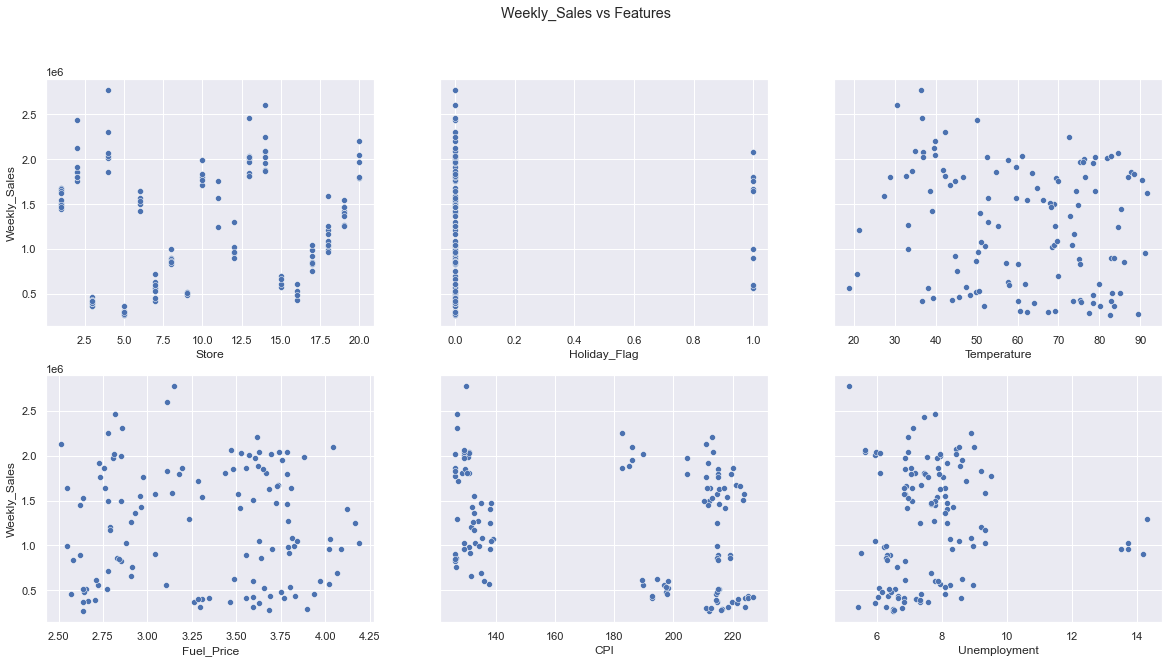

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
fig.suptitle("Weekly_Sales vs Features")

sns.scatterplot(ax=axes[0, 0], x="Store", y="Weekly_Sales", data=df)
sns.scatterplot(ax=axes[0, 1], x="Holiday_Flag", y="Weekly_Sales", data=df)
sns.scatterplot(ax=axes[0, 2], x="Temperature", y="Weekly_Sales", data=df)
sns.scatterplot(ax=axes[1, 0], x="Fuel_Price", y="Weekly_Sales", data=df)
sns.scatterplot(ax=axes[1, 1], x="CPI", y="Weekly_Sales", data=df)
sns.scatterplot(ax=axes[1, 2], x="Unemployment", y="Weekly_Sales", data=df);

- *Store*, *Temperature*, *Fuel_Price*, *CPI* seem well distributed
- more sales when *Holidays_Flag* = 0
- more sales when *Unemployment* est faible

CPI            0.287227
Temperature    0.165991
Store          0.115964
Name: Weekly_Sales, dtype: float64

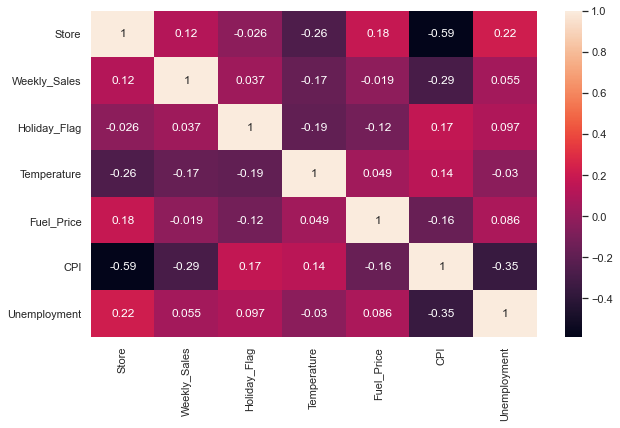

In [16]:
fig = plt.figure(1, figsize=(10, 6))
sns.heatmap(df.corr(), annot=True)
df.corr()["Weekly_Sales"].abs().sort_values(ascending=False).iloc[1:4]

In [17]:
print(100*df.isnull().sum()/df.shape[0])
df.describe(include="all")

Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [18]:
# drop the lines in the dataset for which the value in Weekly_Sales is missing
mask = ~df.Weekly_Sales.isnull()
df = df.loc[mask, :]
df = df.reset_index(drop=True)
print(df.shape)

# drop lines containing invalid values or outliers [Xˉ−3σ, Xˉ+3σ]
list_ = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for elt in list_:
    mask = (df[elt] < df[elt].mean() + 3*df[elt].std()) & (df[elt] > df[elt].mean() - 3*df[elt].std())
    df = df.loc[mask, :]
print(df.shape)

# drop the lines in the dataset for which the value in Date is missing
mask = ~df.Date.isnull()
df = df.loc[mask, :]
df = df.reset_index(drop=True)
print(df.shape)

# create usable features from the Date column
df.Date = pd.to_datetime(df.Date, format="%d-%m-%Y")
df["Year"] = df.Date.dt.year
df["Month"] = df.Date.dt.month
df["Day"] = df.Date.dt.day
df["DayOfWeek"] = df.Date.dt.dayofweek
print(df.shape)

# drop Date column
df.drop(["Date"], axis=1, inplace=True)
print(df.shape)
print(100*df.isnull().sum()/df.shape[0])
df.head()

(136, 8)
(90, 8)
(80, 8)
(80, 12)
(80, 11)
Store            0.00
Weekly_Sales     0.00
Holiday_Flag    11.25
Temperature      0.00
Fuel_Price       0.00
CPI              0.00
Unemployment     0.00
Year             0.00
Month            0.00
Day              0.00
DayOfWeek        0.00
dtype: float64


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
2,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
3,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4
4,20.0,2203523.20,0.0,39.93,3.617,213.023623,6.961,2012,2,3,4


In [19]:
# split X Y
features = ["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "DayOfWeek"]
target = ["Weekly_Sales"]

X = df.loc[:, features]
y = df.loc[:, target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# copy X/Y train/test values before fitting for later
X_train_without_store = X_train.copy()
X_test_without_store = X_test.copy()
y_train_without_store = y_train.copy()
y_test_without_store = y_test.copy()

X

# random_state: to control the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,6.0,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13.0,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
2,6.0,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
3,15.0,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4
4,20.0,0.0,39.93,3.617,213.023623,6.961,2012,2,3,4
...,...,...,...,...,...,...,...,...,...,...
75,7.0,0.0,50.60,3.804,197.588605,8.090,2012,5,25,4
76,3.0,0.0,78.53,2.705,214.495838,7.343,2010,6,4,4
77,3.0,0.0,73.44,3.594,226.968844,6.034,2012,10,19,4
78,14.0,0.0,72.62,2.780,182.442420,8.899,2010,6,18,4


In [20]:
# pipeline numeric & categorical

# Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek
numeric_features = [2, 3, 4, 5, 6, 7, 8, 9]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Store, Holiday_Flag
categorical_features = [0, 1]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")) # drop="first"
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape

(64, 29)

### Baseline model (linear regression)

In [21]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

print("R2-Score Train: %.5f" % (regressor.score(X_train, y_train)))
print("R2-Score Test: %.5f" % (regressor.score(X_test, y_test)))
print("Difference Train/Test: %.2f%%" % ((regressor.score(X_train, y_train)-regressor.score(X_test, y_test)) * 100))

R2-Score Train: 0.98362
R2-Score Test: 0.95847
Difference Train/Test: 2.51%


#### **Linear Regression**

*Equation:*
$$Y = \beta_{0} + \beta_{1}X_1 + \epsilon$$

> $Y$ = target variable<br>
> $X_1$ = features<br>
> $\beta_0$ =  constant, where your line will start if $\beta_{1}$=0<br>
> $\beta_{1}$ = coefficient, represents the slope or weight of your variables<br>
> $\epsilon$ = residual, all the information that is not explained by the model<br>

*Loss Function:*
$$Min (\sum_{i=1}^{n}(y_{i}-\beta{0}-\beta_{1}x_{i})^2)$$

> - Minimize the sum of square errors between the target variable and the prediction<br>

*Evaluation:*
$$R^{2} = 1 - \frac{\sum_{i=1}^{n}(y_{i}-\hat{y_{i}})^{2}}{\sum_{i=1}^{n}(y_{i}-\bar{y_{i}})^{2}}$$

> - R squared, percentage with which our model explains the target<br>

Numerical columns are:  Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month',
       'Day', 'DayOfWeek'],
      dtype='object')
Categorical columns are:  [array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13., 14.,
       15., 16., 17., 18., 19., 20.]), array([0., 1.])]
All columns name are:  ['Temperature' 'Fuel_Price' 'CPI' 'Unemployment' 'Year' 'Month' 'Day'
 'DayOfWeek' 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 13.0 14.0 15.0
 16.0 17.0 18.0 19.0 20.0 0.0 1.0]


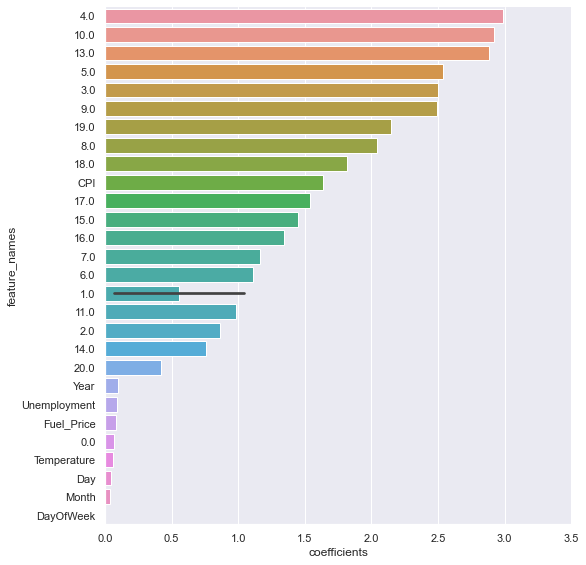

In [22]:
# values of the model's coefficients

# .columns attribute gives us the name of the column
numerical_column_names = X.iloc[:, numeric_features].columns
print("Numerical columns are: ", numerical_column_names)

# access one specific transformer from feature_encoder and print categories
categorical_column_names = preprocessor.transformers_[1][1][1].categories_
print("Categorical columns are: ", categorical_column_names)

# append all columns
all_column_names = np.append(numerical_column_names, categorical_column_names[0])
all_column_names = np.append(all_column_names, categorical_column_names[1])
print("All columns name are: ", all_column_names)

# feature importance
feature_importance = pd.DataFrame(
    {
        "feature_names": all_column_names,
        "coefficients": regressor.coef_.squeeze()
    }
)

# set coefficient to absolute values to rank features
feature_importance["coefficients"] = feature_importance["coefficients"].abs()

# visualize ranked features using seaborn
sns.catplot(
    x="coefficients",
    y="feature_names",
    data=feature_importance.sort_values(by="coefficients", ascending=False),
    kind="bar",
    aspect=1,
    height=8).set_xticklabels(rotation=0);

R2-Score Train: 0.20519
R2-Score Test: 0.13495
Difference Train/Test: 7.02%
Categorical columns are:  [array([0., 1.])]
All columns name are:  ['Temperature' 'Fuel_Price' 'CPI' 'Unemployment' 'Year' 'Month' 'Day'
 'DayOfWeek' 0.0 1.0]


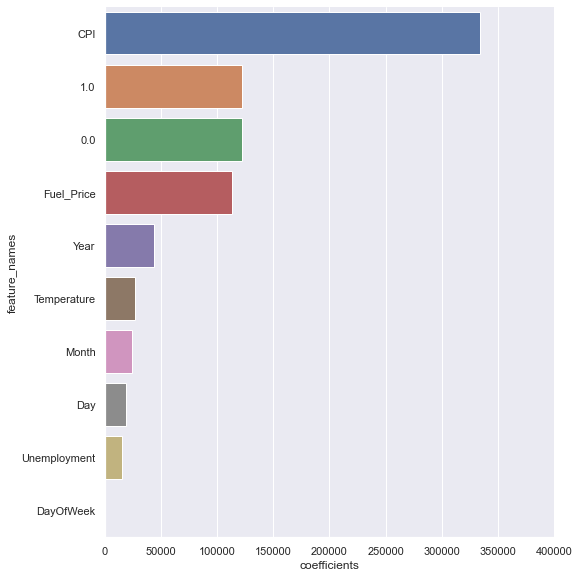

In [23]:
# values of the model's coefficients without Store column

# Holiday_Flag
categorical_features = [1]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train_without_store = preprocessor.fit_transform(X_train_without_store)
X_test_without_store = preprocessor.transform(X_test_without_store)

regressor = LinearRegression()
regressor.fit(X_train_without_store, y_train_without_store)

y_train_pred_without_store = regressor.predict(X_train_without_store)
y_test_pred_without_store = regressor.predict(X_test_without_store)

print("R2-Score Train: %.5f" % (regressor.score(X_train_without_store, y_train_without_store)))
print("R2-Score Test: %.5f" % (regressor.score(X_test_without_store, y_test_without_store)))
print("Difference Train/Test: %.2f%%" % ((regressor.score(X_train_without_store, y_train_without_store)-regressor.score(X_test_without_store, y_test_without_store)) * 100))

# access one specific transformer from feature_encoder and print categories
categorical_column_names = preprocessor.transformers_[1][1][1].categories_
print("Categorical columns are: ", categorical_column_names)

# append all columns
all_column_names = np.append(numerical_column_names, categorical_column_names)
print("All columns name are: ", all_column_names)

# feature importance
feature_importance = pd.DataFrame(
    {
        "feature_names": all_column_names,
        "coefficients": regressor.coef_.squeeze()
    }
)

# set coefficient to absolute values to rank features
feature_importance["coefficients"] = feature_importance["coefficients"].abs()

# visualize ranked features using seaborn
sns.catplot(
    x="coefficients",
    y="feature_names",
    data=feature_importance.sort_values(by="coefficients", ascending=False),
    kind="bar",
    aspect=1,
    height=8).set_xticklabels(rotation=0);

CPI measure inflation over a period and therefore the evolution of the value of the currency.

### Fight overfitting

In [31]:
params_ridge = {
    "alpha": np.arange(0, 10, 0.01)
}

params_lasso = {
    "alpha": [10**(-a) for a in range(10)], "max_iter": [500]
}

model_linear = [
    {"Ridge L2": GridSearchCV(Ridge(), param_grid=params_ridge, cv=3, verbose=1)},
    {"Lasso L1": GridSearchCV(Lasso(), param_grid=params_lasso, cv=3, verbose=1)}
]

def model_fit(X_train, X_test, y_train, y_test, model, title):
    grid_fit = model.fit(X_train, y_train)
    
    print(title)
    print(f"Optimal Alpha Value: {grid_fit.best_estimator_}")
    print("R2-Score Train: %.5f" % (grid_fit.best_estimator_.score(X_train, y_train)))
    print("R2-Score Test: %.5f" % (grid_fit.best_estimator_.score(X_test, y_test)))
    print("Difference Train/Test: %.2f%%" % ((grid_fit.best_estimator_.score(X_train, y_train)-grid_fit.best_estimator_.score(X_test, y_test)) * 100))
    
    scores = cross_val_score(grid_fit.best_estimator_, X_train, y_train, cv=3)
    print("Cross-validated R2-Score: %.5f" % (scores.mean()))
    print("Standard deviation: %.5f" % (scores.std()))
    print()

In [32]:
for count, elt in enumerate(model_linear):
    title = list(elt.keys())[0]
    model = list(elt.values())[0]
    model_fit(X_train, X_test, y_train, y_test, model, title)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:   19.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge L2
Optimal Alpha Value: Ridge(alpha=0.08)
R2-Score Train: 0.97978
R2-Score Test: 0.97730
Difference Train/Test: 0.25%
Cross-validated R2-Score: 0.76217
Standard deviation: 0.20509

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Lasso L1
Optimal Alpha Value: Lasso(alpha=1e-09, max_iter=500)
R2-Score Train: 0.98129
R2-Score Test: 0.97551
Difference Train/Test: 0.58%
Cross-validated R2-Score: 0.78393
Standard deviation: 0.16142



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


#### **Simple Definition**

> bias: mean deviation from the true function<br>
> variance: the amount of variation of the predictions<br>
> noise: the amount of information that cannot be explained by the model<br>

#### **Ridge Regularization L2**

*Equation:*
$$\min_\beta E(\alpha, \beta) = \sum_{i=1}^n (y_i - X_i\beta)^2 + \alpha \lVert \beta \rVert ^2$$

> - Linear regression with a quadratic constraint on the coefficients<br>
> - Control the variance and bias proportions<br>
> - Forces the model to favour parameters features that contain relevant information to describe the target variable and keep parameters features that are not relevant close to zero<br>

*Parameter:*

> alpha = 0 = linear model<br>
> alpha increases / bias increases / variance decreases<br>

#### **Lasso Regularization L1**

*Equation:*
$$\min_\beta E(\alpha, \beta) = \sum_{i=1}^n (y_i - X_i\beta)^2 + \alpha \lVert \beta \rVert$$

> - Linear regression with a linear constraint on the coefficients<br>
> - Ridge does not penalize uninformative variables enough<br>
> - Lasso is able to select the relevant variables and sets the coefficients of the meaningless variables to zero.<br>
> - Lasso can be used to select the best variables<br>

*Parameter:*

> alpha = 0 = linear model<br>
> alpha increases / bias increases / variance decreases<br>
> alpha decreases / number of non-zero coefficients increases<br>

#### **Cross Validation**

> - Gives information on how the model performs, and how stable or unstable its performance is depending on the data distribution<br>